# Baseline Model

In [32]:

%load_ext autoreload
%autoreload 2

# Import library
import torch
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from pytorch_tabnet.tab_model import TabNetClassifier
import sys

fp_project_folder = "../../"
sys.path.append(fp_project_folder)

from src.models.mlp.tuning import tune_model
from src.models.mlp.training import train_baseline
from src.display import display_tuning_df
from src.saving import save_hyperparameters, load_hyperparameters, save_predictions
from src.models.mlp.training import get_baseline_model
from src.models.mlp.evaluate import evaluate_baseline, run_experiment_mlp_repetition
from src.misc import set_seed
from src.models.scikitlearn.training import train_n_evaluate_scikitlearn_classifiers, run_experiment_scikitlearn_repetition
from src.models.scikitlearn.training import tune_scikitlearn_classifiers
from src.preprocessing.tabular_preprocessing import choose_output_cols

from src.configs.config import fp_checkpoint_folder, fp_data_folder # Edit this
# File Paths
fp_project_folder = os.path.join("../")
fp_col_info_file = os.path.join(fp_data_folder, "col_info.joblib")
fp_data_dfs_file = os.path.join(fp_data_folder, "data_dfs.joblib")

seed_no = 2024
batch_size=16
repetitions=5

print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## Load Data

In [2]:
data_dfs = joblib.load(fp_data_dfs_file)
col_info = joblib.load(fp_col_info_file)
col_info = choose_output_cols(col_info, bilateral=False)

## Training MLP
### Tuning

{'num_layers': 1, 'width': 64}:   0%|                                                           | 0/12 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 176.
Epoch 196: early stopping


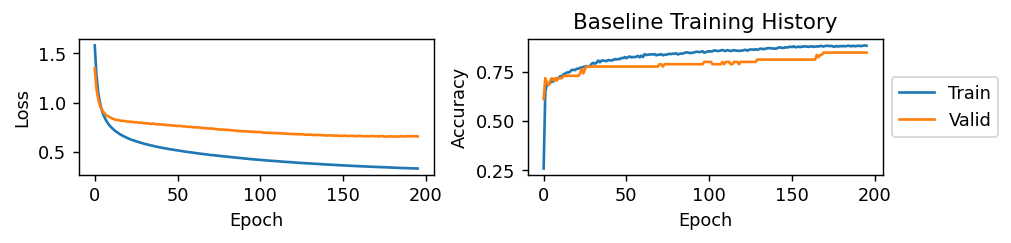

{'num_layers': 1, 'width': 128}:   8%|████▏                                             | 1/12 [00:36<06:41, 36.50s/it]

Restoring model weights from the end of the best epoch: 176.
Epoch 196: early stopping


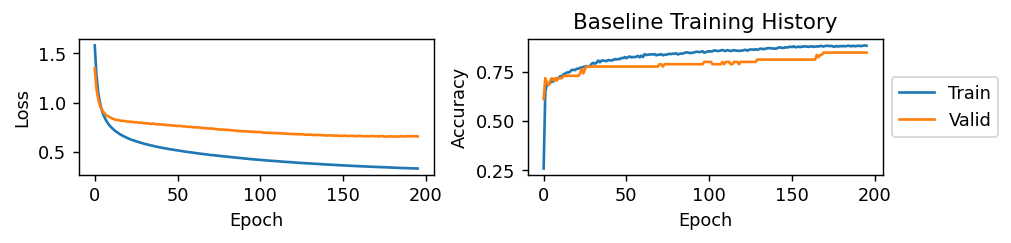

{'num_layers': 1, 'width': 256}:  17%|████████▎                                         | 2/12 [01:06<05:25, 32.60s/it]

Restoring model weights from the end of the best epoch: 176.
Epoch 196: early stopping


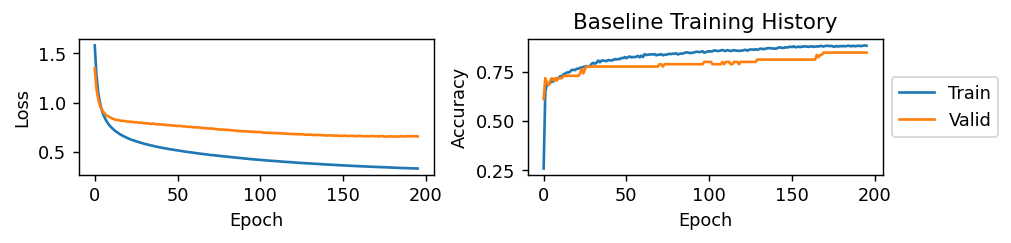

{'num_layers': 2, 'width': 64}:  25%|████████████▊                                      | 3/12 [01:36<04:44, 31.57s/it]

Restoring model weights from the end of the best epoch: 36.
Epoch 56: early stopping


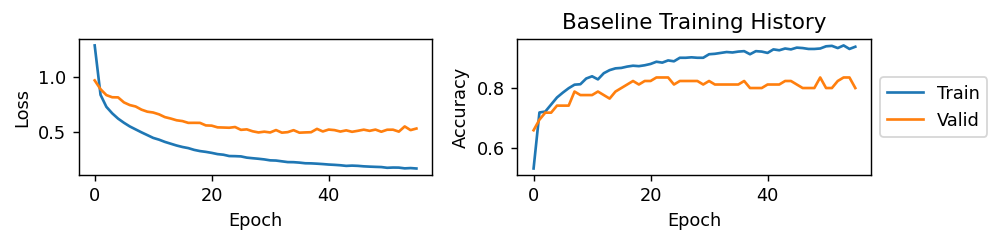

{'num_layers': 2, 'width': 128}:  33%|████████████████▋                                 | 4/12 [01:48<03:08, 23.57s/it]

Restoring model weights from the end of the best epoch: 29.
Epoch 49: early stopping


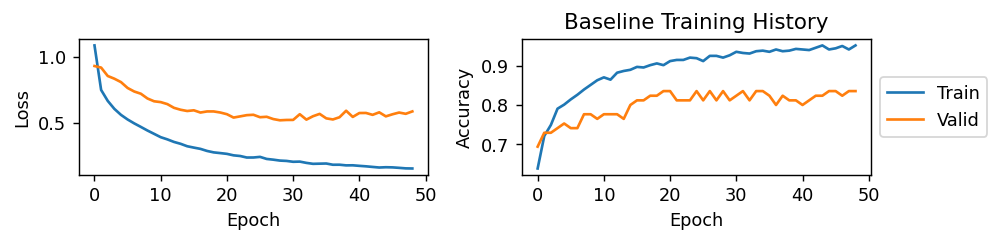

{'num_layers': 2, 'width': 256}:  42%|████████████████████▊                             | 5/12 [01:59<02:14, 19.25s/it]

Restoring model weights from the end of the best epoch: 22.
Epoch 42: early stopping


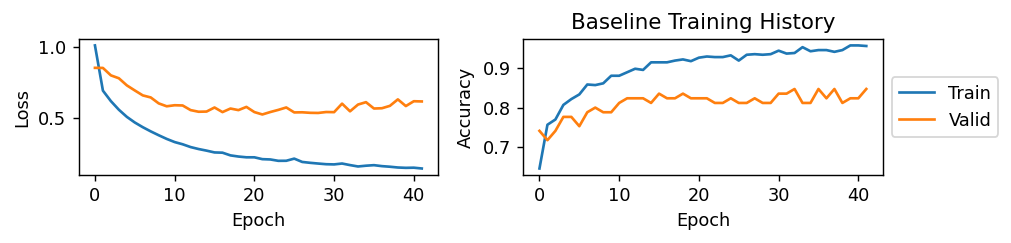

{'num_layers': 3, 'width': 64}:  50%|█████████████████████████▌                         | 6/12 [02:10<01:39, 16.57s/it]

Restoring model weights from the end of the best epoch: 22.
Epoch 42: early stopping


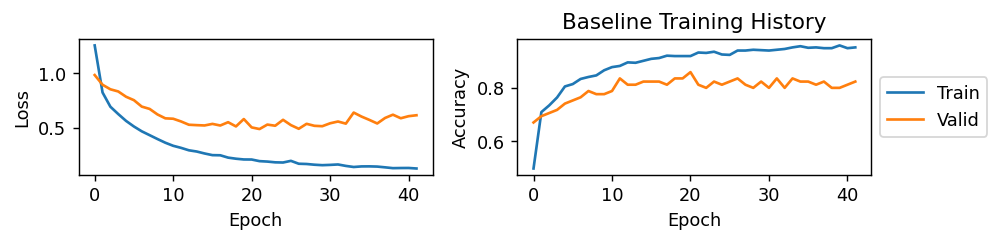

{'num_layers': 3, 'width': 128}:  58%|█████████████████████████████▏                    | 7/12 [02:21<01:12, 14.50s/it]

Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping


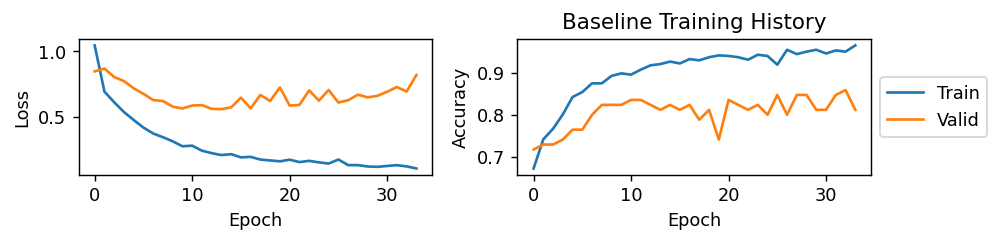

{'num_layers': 3, 'width': 256}:  67%|█████████████████████████████████▎                | 8/12 [02:27<00:47, 11.93s/it]

Restoring model weights from the end of the best epoch: 10.
Epoch 30: early stopping


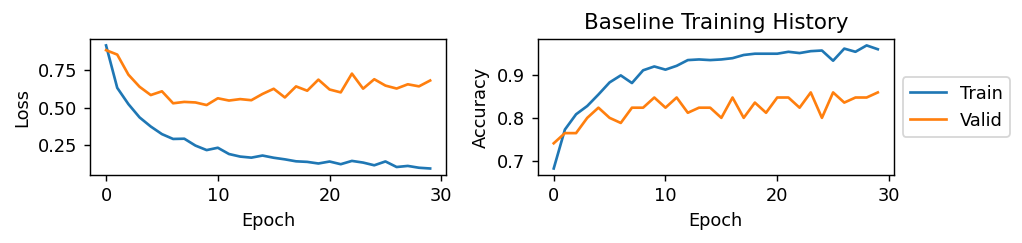

{'num_layers': 4, 'width': 64}:  75%|██████████████████████████████████████▎            | 9/12 [02:33<00:29,  9.94s/it]

Restoring model weights from the end of the best epoch: 13.
Epoch 33: early stopping


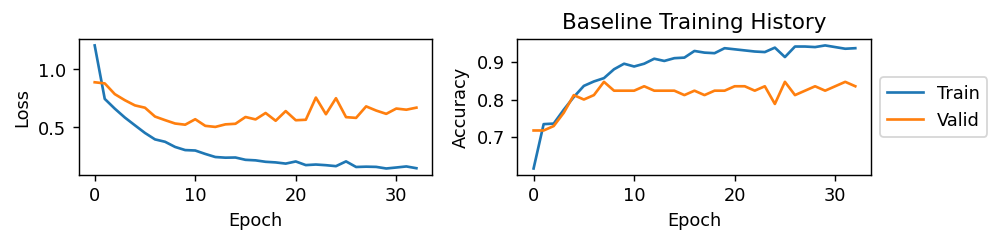

{'num_layers': 4, 'width': 128}:  83%|████████████████████████████████████████▊        | 10/12 [02:40<00:18,  9.17s/it]

Restoring model weights from the end of the best epoch: 10.
Epoch 30: early stopping


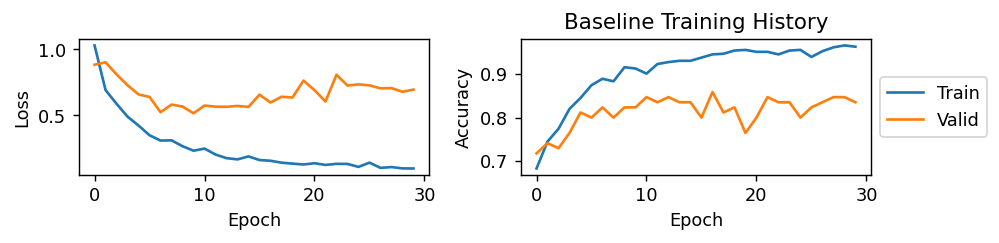

{'num_layers': 4, 'width': 256}:  92%|████████████████████████████████████████████▉    | 11/12 [02:47<00:08,  8.37s/it]

Restoring model weights from the end of the best epoch: 7.
Epoch 27: early stopping


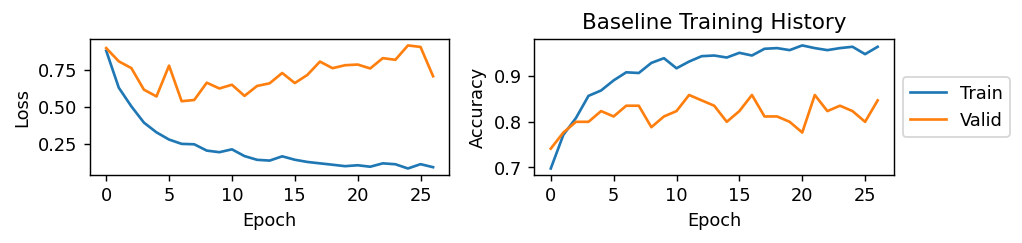

{'num_layers': 4, 'width': 256}: 100%|█████████████████████████████████████████████████| 12/12 [02:53<00:00, 14.45s/it]

{'num_layers': 3, 'width': 64}


,num_layers,width,valid_loss,best_epoch,training_time/s,best_hyperparameter
0,1,64,0.656366,175,36.494264,False
1,1,128,0.656366,175,29.868811,False
2,1,256,0.656366,175,30.338703,False
3,2,64,0.494665,35,11.316383,False
4,2,128,0.516888,28,11.561163,False
5,2,256,0.521927,21,11.368954,False
6,3,64,0.491556,21,10.244359,True
7,3,128,0.558837,13,6.421047,False
8,3,256,0.517019,9,5.568165,False
9,4,64,0.504077,12,7.448738,False


In [12]:
baseline_best_hyperparameters, baseline_tuning_df = tune_model(
    **data_dfs, col_info=col_info,
    hyperparameter_list_dict=dict(
        width=[64, 128, 256], num_layers=[1, 2, 3, 4]
    ), 
    train_function=train_baseline, 
    batch_size=batch_size, max_epochs=1000, patience=20, verbose=0, seed=seed_no,
)
print(baseline_best_hyperparameters)
display_tuning_df(baseline_tuning_df)

In [13]:
# Save Hyperparameters
save_hyperparameters(
    best_hyperparameters=baseline_best_hyperparameters, tuning_df=baseline_tuning_df, 
    name="baseline", fp_checkpoint_folder=fp_checkpoint_folder, override=True
)

Checkpoint exist!
Hyperparameters Saved!


In [14]:
# Load Hyperparameters
baseline_best_hyperparameters, baseline_tuning_df  = load_hyperparameters(name="baseline", fp_checkpoint_folder=fp_checkpoint_folder)
print(baseline_best_hyperparameters)
display_tuning_df(baseline_tuning_df)

{'num_layers': 3, 'width': 64}


,num_layers,width,valid_loss,best_epoch,training_time/s,best_hyperparameter
0,1,64,0.656366,175,36.494264,False
1,1,128,0.656366,175,29.868811,False
2,1,256,0.656366,175,30.338703,False
3,2,64,0.494665,35,11.316383,False
4,2,128,0.516888,28,11.561163,False
5,2,256,0.521927,21,11.368954,False
6,3,64,0.491556,21,10.244359,True
7,3,128,0.558837,13,6.421047,False
8,3,256,0.517019,9,5.568165,False
9,4,64,0.504077,12,7.448738,False


### Training

Epoch 1/1000
43/43 [==============================] - 1s 10ms/step - loss: 1.2557 - categorical_crossentropy: 1.2557 - accuracy: 0.4985 - val_loss: 0.9850 - val_categorical_crossentropy: 0.9850 - val_accuracy: 0.6706
Epoch 2/1000
43/43 [==============================] - 0s 5ms/step - loss: 0.8258 - categorical_crossentropy: 0.8258 - accuracy: 0.7094 - val_loss: 0.8964 - val_categorical_crossentropy: 0.8964 - val_accuracy: 0.6941
Epoch 3/1000
43/43 [==============================] - 0s 5ms/step - loss: 0.6955 - categorical_crossentropy: 0.6955 - accuracy: 0.7345 - val_loss: 0.8548 - val_categorical_crossentropy: 0.8548 - val_accuracy: 0.7059
Epoch 4/1000
43/43 [==============================] - 0s 5ms/step - loss: 0.6286 - categorical_crossentropy: 0.6286 - accuracy: 0.7640 - val_loss: 0.8350 - val_categorical_crossentropy: 0.8350 - val_accuracy: 0.7176
Epoch 5/1000
43/43 [==============================] - 0s 5ms/step - loss: 0.5658 - categorical_crossentropy: 0.5658 - accuracy: 0.8053 

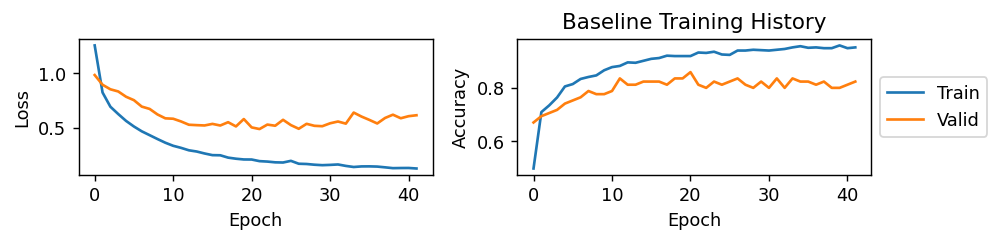

3/3 [==============================] - 0s 6ms/step


,Train,Valid,Test
Accuracy Total_Time_1.0,0.667,0.000,NaN
Accuracy Total_Time_13.0,0.658,0.455,0.500
Accuracy Total_Time_26.0,0.962,0.929,0.963
Accuracy Total_Time_4.33,1.000,0.200,0.875
Accuracy Total_Time_52.0,0.997,0.949,0.974
Final Classifier Accuracy,0.932,0.812,0.906
Final Classifier Crossentropy,0.183,0.491,0.328
Total_Time_1.0 Proportion,0.004,0.024,0.000
Total_Time_13.0 Proportion,0.164,0.129,0.141
Total_Time_26.0 Proportion,0.268,0.329,0.318


,Total_Time_1.0,Total_Time_4.33,Total_Time_13.0,Total_Time_26.0,Total_Time_52.0,Total_Time_1.0_pred,Total_Time_4.33_pred,Total_Time_13.0_pred,Total_Time_26.0_pred,Total_Time_52.0_pred,split
0,0.0,0.0,1.0,0.0,0.0,0.000772,0.000166,0.997361,0.001605,0.000096,train
1,0.0,0.0,0.0,0.0,1.0,0.000137,0.000085,0.002191,0.000036,0.997550,train
2,0.0,0.0,0.0,0.0,1.0,0.000569,0.000200,0.024184,0.000614,0.974433,train
3,0.0,0.0,0.0,1.0,0.0,0.000162,0.006852,0.011235,0.981737,0.000014,train
4,0.0,0.0,0.0,0.0,1.0,0.000200,0.000088,0.002397,0.000024,0.997290,train
...,...,...,...,...,...,...,...,...,...,...,...
843,0.0,0.0,0.0,1.0,0.0,0.000363,0.012635,0.030011,0.956976,0.000015,test
844,0.0,0.0,1.0,0.0,0.0,0.006212,0.011694,0.956743,0.025167,0.000184,test
845,0.0,0.0,0.0,0.0,1.0,0.000443,0.000062,0.002678,0.000057,0.996761,test
846,0.0,0.0,0.0,1.0,0.0,0.001856,0.010383,0.081395,0.905269,0.001098,test


In [ ]:
set_seed(seed_no)
baseline_model = get_baseline_model(
    num_input_cols=len(col_info["input_cols"])*2, 
    num_output_cols=len(col_info["output_cols"]),
    **baseline_best_hyperparameters
)
train_baseline(
    baseline_model, **data_dfs, col_info=col_info,
    batch_size=batch_size, max_epochs=1000, patience=20, verbose=1, seed=seed_no
)
baseline_perf_df, baseline_pred_df = evaluate_baseline(baseline_model, col_info=col_info, **data_dfs)
display(baseline_perf_df)
display(baseline_pred_df)

In [16]:
# Save model
fp_baseline_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "baseline")
# ae_bilateral_model(tf.random.normal((2*num_input_cols)))
baseline_model.save(fp_baseline_model_checkpoint)

INFO:tensorflow:Assets written to: ./checkpoints\models\baseline\assets


In [17]:
# Load model
fp_baseline_model_checkpoint = os.path.join(fp_checkpoint_folder, "models", "baseline")
baseline_model = tf.keras.models.load_model(fp_baseline_model_checkpoint)
baseline_perf_df, baseline_pred_df = evaluate_baseline(baseline_model, col_info=col_info, **data_dfs)
display(baseline_perf_df)
display(baseline_pred_df)

3/3 [==============================] - 0s 0s/step


,Train,Valid,Test
Accuracy Total_Time_1.0,0.667,0.000,NaN
Accuracy Total_Time_13.0,0.658,0.455,0.500
Accuracy Total_Time_26.0,0.962,0.929,0.963
Accuracy Total_Time_4.33,1.000,0.200,0.875
Accuracy Total_Time_52.0,0.997,0.949,0.974
Final Classifier Accuracy,0.932,0.812,0.906
Final Classifier Crossentropy,0.183,0.491,0.328
Total_Time_1.0 Proportion,0.004,0.024,0.000
Total_Time_13.0 Proportion,0.164,0.129,0.141
Total_Time_26.0 Proportion,0.268,0.329,0.318


,Total_Time_1.0,Total_Time_4.33,Total_Time_13.0,Total_Time_26.0,Total_Time_52.0,Total_Time_1.0_pred,Total_Time_4.33_pred,Total_Time_13.0_pred,Total_Time_26.0_pred,Total_Time_52.0_pred,split
0,0.0,0.0,1.0,0.0,0.0,0.000772,0.000166,0.997361,0.001605,0.000096,train
1,0.0,0.0,0.0,0.0,1.0,0.000137,0.000085,0.002191,0.000036,0.997550,train
2,0.0,0.0,0.0,0.0,1.0,0.000569,0.000200,0.024184,0.000614,0.974433,train
3,0.0,0.0,0.0,1.0,0.0,0.000162,0.006852,0.011235,0.981737,0.000014,train
4,0.0,0.0,0.0,0.0,1.0,0.000200,0.000088,0.002397,0.000024,0.997290,train
...,...,...,...,...,...,...,...,...,...,...,...
843,0.0,0.0,0.0,1.0,0.0,0.000363,0.012635,0.030011,0.956976,0.000015,test
844,0.0,0.0,1.0,0.0,0.0,0.006212,0.011694,0.956743,0.025167,0.000184,test
845,0.0,0.0,0.0,0.0,1.0,0.000443,0.000062,0.002678,0.000057,0.996761,test
846,0.0,0.0,0.0,1.0,0.0,0.001856,0.010383,0.081395,0.905269,0.001098,test


In [18]:
save_predictions(prediction_df=baseline_pred_df, name="baseline", fp_checkpoint_folder=fp_checkpoint_folder)

Predictions Saved!


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/1000


I0000 00:00:1740387144.729821 3075619 service.cc:146] XLA service 0x757ca8008870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740387144.729857 3075619 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740387144.729861 3075619 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740387144.729862 3075619 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740387144.729864 3075619 service.cc:154]   StreamExecutor device (3): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-24 15:52:24.766503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 15:52:24.835602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 1/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3125 - categorical_crossentropy: 1.5875 - loss: 1.5875

2025-02-24 15:52:25.188733: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1740387145.372711 3075619 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3890 - categorical_crossentropy: 1.3857 - loss: 1.3857 - val_accuracy: 0.6706 - val_categorical_crossentropy: 0.9850 - val_loss: 0.9850
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7269 - categorical_crossentropy: 0.8648 - loss: 0.8648 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8632 - val_loss: 0.8632
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7349 - categorical_crossentropy: 0.6775 - loss: 0.6775 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8601 - val_loss: 0.8601
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7703 - categorical_crossentropy: 0.6127 - loss: 0.6127 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8304 - val_loss: 0.8304
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - categorical_crossentropy: 0.5626 - loss: 0.5626 - val_accuracy: 0.7529 - val_categorical_crossentropy: 0.7931 - val_loss: 0.7931
Ep

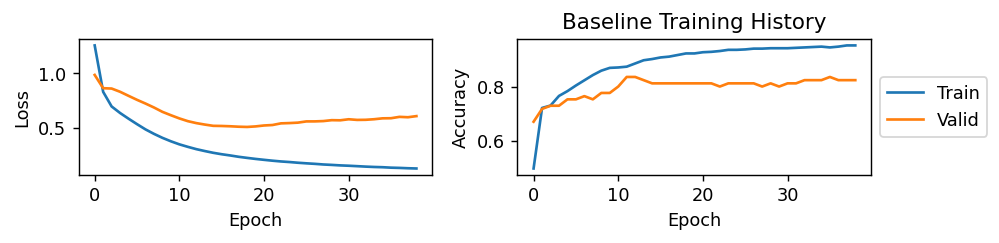

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5110 - categorical_crossentropy: 1.3604 - loss: 1.3604 - val_accuracy: 0.7059 - val_categorical_crossentropy: 0.8953 - val_loss: 0.8953
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7135 - categorical_crossentropy: 0.7880 - loss: 0.7880 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8661 - val_loss: 0.8661
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7306 - categorical_crossentropy: 0.6744 - loss: 0.6744 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8432 - val_loss: 0.8432
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7429 - categorical_crossentropy: 0.6133 - loss: 0.6133 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8114 - val_loss: 0.8114
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7672 - ca

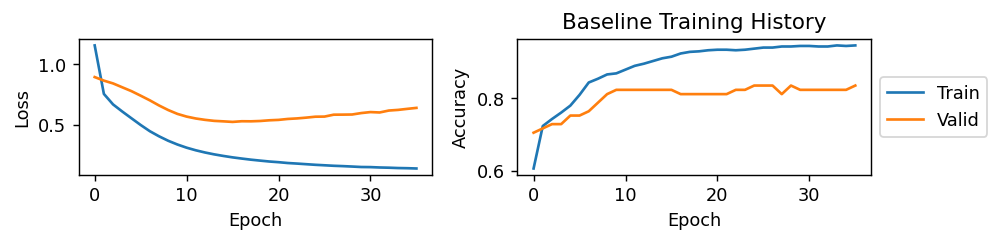

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5062 - categorical_crossentropy: 1.3521 - loss: 1.3521 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8910 - val_loss: 0.8910
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7322 - categorical_crossentropy: 0.7908 - loss: 0.7908 - val_accuracy: 0.7529 - val_categorical_crossentropy: 0.8358 - val_loss: 0.8358
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7616 - categorical_crossentropy: 0.6775 - loss: 0.6775 - val_accuracy: 0.7412 - val_categorical_crossentropy: 0.8009 - val_loss: 0.8009
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7829 - categorical_crossentropy: 0.6163 - loss: 0.6163 - val_accuracy: 0.7647 - val_categorical_crossentropy: 0.7669 - val_loss: 0.7669
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7994 - ca

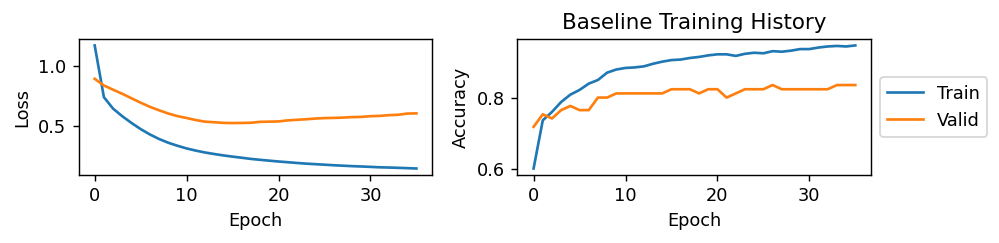

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4070 - categorical_crossentropy: 1.4281 - loss: 1.4281 - val_accuracy: 0.6706 - val_categorical_crossentropy: 0.9913 - val_loss: 0.9913
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6696 - categorical_crossentropy: 0.9182 - loss: 0.9182 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8821 - val_loss: 0.8821
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7173 - categorical_crossentropy: 0.7604 - loss: 0.7604 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8641 - val_loss: 0.8641
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7558 - categorical_crossentropy: 0.6832 - loss: 0.6832 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8344 - val_loss: 0.8344
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7870 - ca

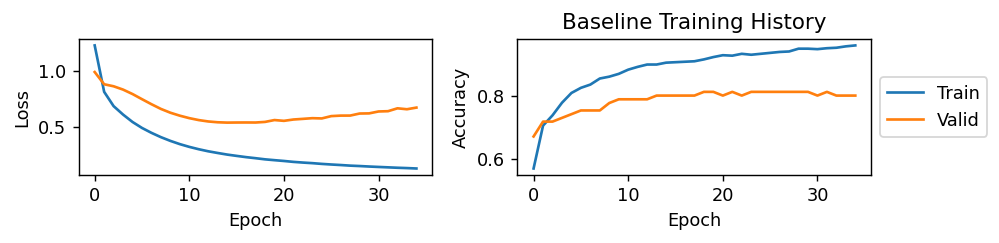

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
Epoch 1/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4284 - categorical_crossentropy: 1.3417 - loss: 1.3417 - val_accuracy: 0.6706 - val_categorical_crossentropy: 0.9277 - val_loss: 0.9277
Epoch 2/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7238 - categorical_crossentropy: 0.7852 - loss: 0.7852 - val_accuracy: 0.6941 - val_categorical_crossentropy: 0.9149 - val_loss: 0.9149
Epoch 3/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7366 - categorical_crossentropy: 0.6929 - loss: 0.6929 - val_accuracy: 0.7176 - val_categorical_crossentropy: 0.8997 - val_loss: 0.8997
Epoch 4/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7900 - categorical_crossentropy: 0.6313 - loss: 0.6313 - val_accuracy: 0.7294 - val_categorical_crossentropy: 0.8737 - val_loss: 0.8737
Epoch 5/1000
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8140 - ca

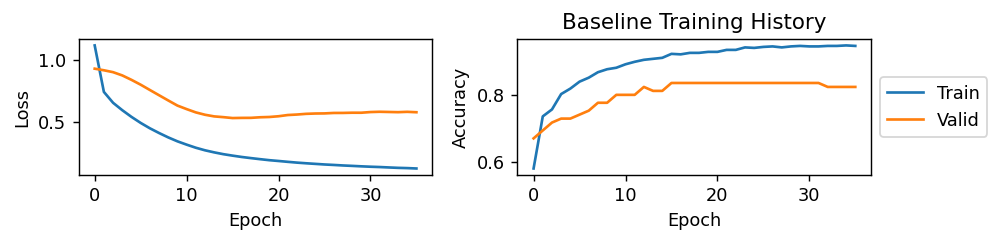

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


,Train,Valid,Test
Accuracy Total_Time_1.0,0.133 ± 0.163,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,0.596 ± 0.121,0.418 ± 0.093,0.483 ± 0.062
Accuracy Total_Time_26.0,0.947 ± 0.019,0.921 ± 0.042,0.941 ± 0.030
Accuracy Total_Time_4.33,0.983 ± 0.008,0.200 ± 0.000,0.825 ± 0.061
Accuracy Total_Time_52.0,0.989 ± 0.008,0.949 ± 0.016,0.979 ± 0.020
Final Classifier Accuracy,0.919 ± 0.011,0.819 ± 0.012,0.892 ± 0.005
Final Classifier Crossentropy,0.231 ± 0.013,0.526 ± 0.011,0.345 ± 0.014
Total_Time_1.0 Proportion,0.004 ± 0.000,0.024 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.164 ± 0.000,0.129 ± 0.000,0.141 ± 0.000
Total_Time_26.0 Proportion,0.268 ± 0.000,0.329 ± 0.000,0.318 ± 0.000


In [34]:
mlp_best_param = {'num_layers': 3, 'width': 64}
mlp_repetition_perf_df = run_experiment_mlp_repetition(
    param=mlp_best_param, 
    data_dfs=data_dfs, col_info=col_info, batch_size=batch_size, 
    repetitions=repetitions, seed=seed_no, dp=3
)
mlp_repetition_perf_df

## Train RandomForestClassifier

### Tuning

In [66]:
tuning_df_rf, best_params_rf = tune_scikitlearn_classifiers(
    param_grid={"n_estimators":[50, 100, 200, 400, 800]},
    **data_dfs, col_info=col_info, 
    Classifier= RandomForestClassifier, 
    seed=seed_no
)
display(tuning_df_rf)
print(f"Best Param: {best_params_rf}")

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tuning_df[best_col].iloc[

,n_estimators,val_acc,time/s,best
0,50,0.800,0.087934,False
1,100,0.788,0.172478,False
2,200,0.812,0.375186,True
3,400,0.788,0.680045,False
4,800,0.800,1.325280,False


Best Param: {'n_estimators': 200}


### Training

In [ ]:
rfc, rfc_pred_df, rfc_pref_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_rf,
    **data_dfs, col_info=col_info, Classifier=RandomForestClassifier, seed=seed_no
)
display(rfc_pref_df)

,train,valid,test
Accuracy,1.000,0.812,0.871
Accuracy Total_Time_1.0,1.000,0.000,NaN
Accuracy Total_Time_13.0,1.000,0.364,0.500
Accuracy Total_Time_26.0,1.000,0.964,0.926
Accuracy Total_Time_4.33,1.000,0.400,0.625
Accuracy Total_Time_52.0,1.000,0.923,1.000
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


In [24]:
best_params_rf={'n_estimators': 200}
rfc_perf_reptition_df = run_experiment_scikitlearn_repetition(
    param=best_params_rf,
    classifier=RandomForestClassifier, 
    repetitions=repetitions,
    data_dfs=data_dfs, col_info=col_info, 
    seed=seed_no, dp=3
)
rfc_perf_reptition_df

  0%|          | 0/5 [00:00<?, ?it/s]

,train,valid,test
Accuracy,1.000 ± 0.000,0.817 ± 0.006,0.878 ± 0.005
Accuracy Total_Time_1.0,1.000 ± 0.000,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,1.000 ± 0.000,0.364 ± 0.000,0.500 ± 0.000
Accuracy Total_Time_26.0,1.000 ± 0.000,0.964 ± 0.000,0.941 ± 0.018
Accuracy Total_Time_4.33,1.000 ± 0.000,0.400 ± 0.000,0.650 ± 0.050
Accuracy Total_Time_52.0,1.000 ± 0.000,0.933 ± 0.013,1.000 ± 0.000
Total_Time_1.0 Proportion,0.004 ± 0.000,0.002 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.131 ± 0.000,0.013 ± 0.000,0.014 ± 0.000
Total_Time_26.0 Proportion,0.215 ± 0.000,0.033 ± 0.000,0.032 ± 0.000
Total_Time_4.33 Proportion,0.055 ± 0.000,0.006 ± 0.000,0.009 ± 0.000


## Train GradientBoostingClassifier

### Tuning

In [11]:
tuning_df_gb, best_params_gb = tune_scikitlearn_classifiers(
    param_grid={"n_estimators":[50, 100, 200, 400, 800]},
    **data_dfs, col_info=col_info, 
    Classifier=GradientBoostingClassifier, 
    seed=seed_no
)
display(tuning_df_gb)
print(f"Best Param: {best_params_gb}")

100%|██████████| 5/5 [00:18<00:00,  3.68s/it]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tuning_df[best_col].iloc[

,n_estimators,val_acc,time/s,best
0,50,0.859,0.551916,False
1,100,0.894,1.054646,True
2,200,0.871,2.256975,False
3,400,0.859,5.768982,False
4,800,0.847,8.571580,False


Best Param: {'n_estimators': 100}


### Training

In [13]:
gbc, gbc_pred_df, gbc_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_gb,
    **data_dfs, col_info=col_info, Classifier=GradientBoostingClassifier, seed=seed_no
)
display(gbc_perf_df)

,train,valid,test
Accuracy,0.954,0.894,0.871
Accuracy Total_Time_1.0,1.000,0.000,NaN
Accuracy Total_Time_13.0,0.766,0.364,0.417
Accuracy Total_Time_26.0,0.978,1.000,0.963
Accuracy Total_Time_4.33,1.000,1.000,0.625
Accuracy Total_Time_52.0,0.997,1.000,1.000
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


In [26]:
best_params_gbc={'n_estimators': 100}
gbc_perf_reptition_df = run_experiment_scikitlearn_repetition(
    param=best_params_gbc,
    classifier=GradientBoostingClassifier, 
    repetitions=repetitions,
    data_dfs=data_dfs, col_info=col_info, 
    seed=seed_no, dp=3
)
gbc_perf_reptition_df

  0%|          | 0/5 [00:00<?, ?it/s]

,train,valid,test
Accuracy,0.955 ± 0.001,0.894 ± 0.000,0.871 ± 0.000
Accuracy Total_Time_1.0,1.000 ± 0.000,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,0.768 ± 0.004,0.364 ± 0.000,0.417 ± 0.000
Accuracy Total_Time_26.0,0.978 ± 0.000,1.000 ± 0.000,0.963 ± 0.000
Accuracy Total_Time_4.33,1.000 ± 0.000,1.000 ± 0.000,0.625 ± 0.000
Accuracy Total_Time_52.0,0.998 ± 0.001,1.000 ± 0.000,1.000 ± 0.000
Total_Time_1.0 Proportion,0.004 ± 0.000,0.002 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.131 ± 0.000,0.013 ± 0.000,0.014 ± 0.000
Total_Time_26.0 Proportion,0.215 ± 0.000,0.033 ± 0.000,0.032 ± 0.000
Total_Time_4.33 Proportion,0.055 ± 0.000,0.006 ± 0.000,0.009 ± 0.000


## Train AdaBoostClassifier

### Tuning

In [16]:
tuning_df_ab, best_params_ab = tune_scikitlearn_classifiers(
    param_grid={"n_estimators":[25, 50, 100, 200, 400, 800, 1600]},
    **data_dfs, col_info=col_info, 
    Classifier=AdaBoostClassifier, 
    seed=seed_no
)
display(tuning_df_ab)
print(f"Best Param: {best_params_ab}")

100%|██████████| 7/7 [00:07<00:00,  1.14s/it]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tuning_df[best_col].iloc[

,n_estimators,val_acc,time/s,best
0,25,0.706,0.056208,False
1,50,0.729,0.095367,False
2,100,0.741,0.195479,False
3,200,0.765,0.397300,False
4,400,0.788,0.792318,True
5,800,0.788,2.202763,False
6,1600,0.788,3.283139,False


Best Param: {'n_estimators': 400}


### Training

In [17]:
abc, abc_pred_df, abc_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_ab,
    **data_dfs, col_info=col_info, Classifier=AdaBoostClassifier, seed=seed_no
)
display(abc_perf_df)

,train,valid,test
Accuracy,0.732,0.788,0.729
Accuracy Total_Time_1.0,1.000,0.000,NaN
Accuracy Total_Time_13.0,0.162,0.273,0.000
Accuracy Total_Time_26.0,0.786,0.893,0.852
Accuracy Total_Time_4.33,0.191,0.400,0.250
Accuracy Total_Time_52.0,0.964,0.949,0.974
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


In [27]:
best_params_abc={'n_estimators': 400}
abc_perf_reptition_df = run_experiment_scikitlearn_repetition(
    param=best_params_abc,
    classifier=AdaBoostClassifier, 
    repetitions=repetitions,
    data_dfs=data_dfs, col_info=col_info, 
    seed=seed_no, dp=3
)
abc_perf_reptition_df

  0%|          | 0/5 [00:00<?, ?it/s]

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. U

,train,valid,test
Accuracy,0.708 ± 0.000,0.729 ± 0.000,0.694 ± 0.000
Accuracy Total_Time_1.0,0.000 ± 0.000,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,0.108 ± 0.000,0.091 ± 0.000,0.000 ± 0.000
Accuracy Total_Time_26.0,0.747 ± 0.000,0.821 ± 0.000,0.778 ± 0.000
Accuracy Total_Time_4.33,0.021 ± 0.000,0.000 ± 0.000,0.000 ± 0.000
Accuracy Total_Time_52.0,0.988 ± 0.000,0.974 ± 0.000,1.000 ± 0.000
Total_Time_1.0 Proportion,0.004 ± 0.000,0.002 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.131 ± 0.000,0.013 ± 0.000,0.014 ± 0.000
Total_Time_26.0 Proportion,0.215 ± 0.000,0.033 ± 0.000,0.032 ± 0.000
Total_Time_4.33 Proportion,0.055 ± 0.000,0.006 ± 0.000,0.009 ± 0.000


## Train QuadraticDiscriminantAnalysis

### Tuning

In [18]:
tuning_df_qda, best_params_qda = tune_scikitlearn_classifiers(
    param_grid={"reg_param":[0, 0.05, 0.1, 0.2, 0.3]},
    **data_dfs, col_info=col_info, 
    Classifier=QuadraticDiscriminantAnalysis, 
    seed=seed_no
)
display(tuning_df_qda)
print(f"Best Param: {best_params_qda}")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param

,reg_param,val_acc,time/s,best
0,0.00,0.447,0.066286,False
1,0.05,0.729,0.016938,False
2,0.10,0.741,0.019278,False
3,0.20,0.753,0.016615,True
4,0.30,0.753,0.016001,False


Best Param: {'reg_param': 0.2}


### Training

In [20]:
qda, qda_pred_df, qda_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_qda,
    **data_dfs, col_info=col_info, Classifier=QuadraticDiscriminantAnalysis, seed=seed_no
)
display(qda_perf_df)

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


,train,valid,test
Accuracy,0.745,0.753,0.753
Accuracy Total_Time_1.0,0.000,0.000,NaN
Accuracy Total_Time_13.0,0.018,0.000,0.000
Accuracy Total_Time_26.0,1.000,1.000,1.000
Accuracy Total_Time_4.33,0.000,0.000,0.000
Accuracy Total_Time_52.0,0.958,0.923,0.974
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


In [28]:
best_params_qda={'reg_param': 0.2}
qda_perf_reptition_df = run_experiment_scikitlearn_repetition(
    param=best_params_qda,
    classifier=QuadraticDiscriminantAnalysis, 
    repetitions=repetitions,
    data_dfs=data_dfs, col_info=col_info, 
    seed=seed_no, dp=3
)
qda_perf_reptition_df

  0%|          | 0/5 [00:00<?, ?it/s]

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,train,valid,test
Accuracy,0.745 ± 0.000,0.753 ± 0.000,0.753 ± 0.000
Accuracy Total_Time_1.0,0.000 ± 0.000,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,0.018 ± 0.000,0.000 ± 0.000,0.000 ± 0.000
Accuracy Total_Time_26.0,1.000 ± 0.000,1.000 ± 0.000,1.000 ± 0.000
Accuracy Total_Time_4.33,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000
Accuracy Total_Time_52.0,0.958 ± 0.000,0.923 ± 0.000,0.974 ± 0.000
Total_Time_1.0 Proportion,0.004 ± 0.000,0.002 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.131 ± 0.000,0.013 ± 0.000,0.014 ± 0.000
Total_Time_26.0 Proportion,0.215 ± 0.000,0.033 ± 0.000,0.032 ± 0.000
Total_Time_4.33 Proportion,0.055 ± 0.000,0.006 ± 0.000,0.009 ± 0.000


## Train TabNet

### Tuning

In [68]:
tuning_df_tab, best_params_tab = tune_scikitlearn_classifiers(
    param_grid={
        "n_d":[2, 4, 8], 
        "n_a":[2, 4, 8], 
        "cat_emb_dim":[2, 4], 
        "device_name":["cuda"]
    },
    **data_dfs, col_info=col_info, 
    Classifier=TabNetClassifier, 
    seed=seed_no
) # {4, 4}: 0.89412, 
display(tuning_df_tab)
print(f"Best Param: {best_params_tab}")

  0%|          | 0/18 [00:00<?, ?it/s]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.64834 | val_0_accuracy: 0.02353 |  0:00:01s
epoch 1  | loss: 1.46908 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 2  | loss: 1.12086 | val_0_accuracy: 0.65882 |  0:00:04s
epoch 3  | loss: 0.89994 | val_0_accuracy: 0.75294 |  0:00:06s
epoch 4  | loss: 0.87106 | val_0_accuracy: 0.74118 |  0:00:07s
epoch 5  | loss: 0.85798 | val_0_accuracy: 0.75294 |  0:00:09s
epoch 6  | loss: 0.86317 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 7  | loss: 0.7843  | val_0_accuracy: 0.72941 |  0:00:12s
epoch 8  | loss: 0.77753 | val_0_accuracy: 0.74118 |  0:00:13s
epoch 9  | loss: 0.76818 | val_0_accuracy: 0.74118 |  0:00:14s
epoch 10 | loss: 0.74036 | val_0_accuracy: 0.75294 |  0:00:16s
epoch 11 | loss: 0.75378 | val_0_accuracy: 0.75294 |  0:00:18s
epoch 12 | loss: 0.73133 | val_0_accuracy: 0.75294 |  0:00:20s
epoch 13 | loss: 0.73302 | val_0_accuracy: 0.75294 |  0:00:22s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.75294


c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
  6%|▌         | 1/18 [00:23<06:37, 23.36s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38154 | val_0_accuracy: 0.67059 |  0:00:01s
epoch 1  | loss: 1.01034 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 2  | loss: 0.87697 | val_0_accuracy: 0.76471 |  0:00:04s
epoch 3  | loss: 0.74827 | val_0_accuracy: 0.78824 |  0:00:05s
epoch 4  | loss: 0.71453 | val_0_accuracy: 0.78824 |  0:00:06s
epoch 5  | loss: 0.685   | val_0_accuracy: 0.8     |  0:00:08s
epoch 6  | loss: 0.64781 | val_0_accuracy: 0.62353 |  0:00:09s
epoch 7  | loss: 0.6837  | val_0_accuracy: 0.78824 |  0:00:10s
epoch 8  | loss: 0.61976 | val_0_accuracy: 0.78824 |  0:00:11s
epoch 9  | loss: 0.63235 | val_0_accuracy: 0.8     |  0:00:12s
epoch 10 | loss: 0.59937 | val_0_accuracy: 0.8     |  0:00:14s
epoch 11 | loss: 0.60379 | val_0_accuracy: 0.78824 |  0:00:15s
epoch 12 | loss: 0.58793 | val_0_accuracy: 0.78824 |  0:00:16s
epoch 13 | loss: 0.57475 | val_0_accuracy: 0.76471 |  0:00:18s
epoch 14 | loss: 0.58507 | val_0_accuracy: 0.8     |  0:00:20s
epoch 15 | loss: 0.55826 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 11%|█         | 2/18 [01:43<15:11, 56.97s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35064 | val_0_accuracy: 0.44706 |  0:00:01s
epoch 1  | loss: 1.08795 | val_0_accuracy: 0.65882 |  0:00:02s
epoch 2  | loss: 1.00633 | val_0_accuracy: 0.70588 |  0:00:03s
epoch 3  | loss: 0.8644  | val_0_accuracy: 0.75294 |  0:00:04s
epoch 4  | loss: 0.79101 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 5  | loss: 0.75831 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 6  | loss: 0.66127 | val_0_accuracy: 0.69412 |  0:00:08s
epoch 7  | loss: 0.67431 | val_0_accuracy: 0.76471 |  0:00:09s
epoch 8  | loss: 0.68435 | val_0_accuracy: 0.78824 |  0:00:11s
epoch 9  | loss: 0.71384 | val_0_accuracy: 0.77647 |  0:00:13s
epoch 10 | loss: 0.63622 | val_0_accuracy: 0.76471 |  0:00:14s
epoch 11 | loss: 0.63721 | val_0_accuracy: 0.77647 |  0:00:15s
epoch 12 | loss: 0.60105 | val_0_accuracy: 0.77647 |  0:00:16s
epoch 13 | loss: 0.60113 | val_0_accuracy: 0.77647 |  0:00:18s
epoch 14 | loss: 0.6261  | val_0_accuracy: 0.77647 |  0:00:19s
epoch 15 | loss: 0.58599 | val_0_accuracy: 0.77647 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 17%|█▋        | 3/18 [02:10<10:45, 43.03s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45489 | val_0_accuracy: 0.45882 |  0:00:02s
epoch 1  | loss: 1.18849 | val_0_accuracy: 0.54118 |  0:00:03s
epoch 2  | loss: 1.01496 | val_0_accuracy: 0.67059 |  0:00:05s
epoch 3  | loss: 0.9868  | val_0_accuracy: 0.71765 |  0:00:06s
epoch 4  | loss: 0.92196 | val_0_accuracy: 0.70588 |  0:00:07s
epoch 5  | loss: 0.89754 | val_0_accuracy: 0.69412 |  0:00:08s
epoch 6  | loss: 0.85095 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 7  | loss: 0.83682 | val_0_accuracy: 0.67059 |  0:00:11s
epoch 8  | loss: 0.81782 | val_0_accuracy: 0.75294 |  0:00:13s
epoch 9  | loss: 0.79559 | val_0_accuracy: 0.75294 |  0:00:14s
epoch 10 | loss: 0.74047 | val_0_accuracy: 0.76471 |  0:00:17s
epoch 11 | loss: 0.73257 | val_0_accuracy: 0.78824 |  0:00:18s
epoch 12 | loss: 0.71819 | val_0_accuracy: 0.78824 |  0:00:19s
epoch 13 | loss: 0.701   | val_0_accuracy: 0.8     |  0:00:21s
epoch 14 | loss: 0.68192 | val_0_accuracy: 0.78824 |  0:00:22s
epoch 15 | loss: 0.68974 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 22%|██▏       | 4/18 [02:48<09:37, 41.24s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35237 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.17592 | val_0_accuracy: 0.55294 |  0:00:03s
epoch 2  | loss: 0.97632 | val_0_accuracy: 0.71765 |  0:00:05s
epoch 3  | loss: 0.90608 | val_0_accuracy: 0.65882 |  0:00:06s
epoch 4  | loss: 0.88046 | val_0_accuracy: 0.72941 |  0:00:07s
epoch 5  | loss: 0.84133 | val_0_accuracy: 0.71765 |  0:00:09s
epoch 6  | loss: 0.82688 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 7  | loss: 0.78643 | val_0_accuracy: 0.69412 |  0:00:11s
epoch 8  | loss: 0.7833  | val_0_accuracy: 0.74118 |  0:00:13s
epoch 9  | loss: 0.81147 | val_0_accuracy: 0.75294 |  0:00:14s
epoch 10 | loss: 0.72626 | val_0_accuracy: 0.74118 |  0:00:16s
epoch 11 | loss: 0.68121 | val_0_accuracy: 0.74118 |  0:00:17s
epoch 12 | loss: 0.64075 | val_0_accuracy: 0.74118 |  0:00:19s
epoch 13 | loss: 0.68572 | val_0_accuracy: 0.74118 |  0:00:21s
epoch 14 | loss: 0.64746 | val_0_accuracy: 0.75294 |  0:00:23s
epoch 15 | loss: 0.59218 | val_0_accuracy: 0.75294 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 28%|██▊       | 5/18 [04:04<11:38, 53.76s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57192 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.18566 | val_0_accuracy: 0.49412 |  0:00:03s
epoch 2  | loss: 0.98421 | val_0_accuracy: 0.75294 |  0:00:05s
epoch 3  | loss: 0.83181 | val_0_accuracy: 0.75294 |  0:00:07s
epoch 4  | loss: 0.8324  | val_0_accuracy: 0.68235 |  0:00:09s
epoch 5  | loss: 0.73444 | val_0_accuracy: 0.75294 |  0:00:11s
epoch 6  | loss: 0.72286 | val_0_accuracy: 0.72941 |  0:00:12s
epoch 7  | loss: 0.65606 | val_0_accuracy: 0.77647 |  0:00:14s
epoch 8  | loss: 0.70156 | val_0_accuracy: 0.77647 |  0:00:16s
epoch 9  | loss: 0.63741 | val_0_accuracy: 0.76471 |  0:00:18s
epoch 10 | loss: 0.63296 | val_0_accuracy: 0.8     |  0:00:20s
epoch 11 | loss: 0.59731 | val_0_accuracy: 0.78824 |  0:00:21s
epoch 12 | loss: 0.62701 | val_0_accuracy: 0.77647 |  0:00:23s
epoch 13 | loss: 0.62067 | val_0_accuracy: 0.8     |  0:00:24s
epoch 14 | loss: 0.60803 | val_0_accuracy: 0.81176 |  0:00:26s
epoch 15 | loss: 0.56533 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 33%|███▎      | 6/18 [05:17<12:04, 60.34s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55669 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.25425 | val_0_accuracy: 0.47059 |  0:00:02s
epoch 2  | loss: 1.04219 | val_0_accuracy: 0.65882 |  0:00:03s
epoch 3  | loss: 0.89105 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 4  | loss: 0.83959 | val_0_accuracy: 0.74118 |  0:00:06s
epoch 5  | loss: 0.79851 | val_0_accuracy: 0.76471 |  0:00:08s
epoch 6  | loss: 0.74248 | val_0_accuracy: 0.75294 |  0:00:09s
epoch 7  | loss: 0.73814 | val_0_accuracy: 0.75294 |  0:00:10s
epoch 8  | loss: 0.73788 | val_0_accuracy: 0.76471 |  0:00:11s
epoch 9  | loss: 0.68175 | val_0_accuracy: 0.74118 |  0:00:13s
epoch 10 | loss: 0.64816 | val_0_accuracy: 0.77647 |  0:00:15s
epoch 11 | loss: 0.64218 | val_0_accuracy: 0.77647 |  0:00:16s
epoch 12 | loss: 0.61437 | val_0_accuracy: 0.68235 |  0:00:18s
epoch 13 | loss: 0.60879 | val_0_accuracy: 0.72941 |  0:00:20s
epoch 14 | loss: 0.60099 | val_0_accuracy: 0.77647 |  0:00:22s
epoch 15 | loss: 0.56066 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 39%|███▉      | 7/18 [06:22<11:20, 61.85s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51705 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 1  | loss: 1.15779 | val_0_accuracy: 0.48235 |  0:00:09s
epoch 2  | loss: 1.02912 | val_0_accuracy: 0.67059 |  0:00:13s
epoch 3  | loss: 0.89443 | val_0_accuracy: 0.68235 |  0:00:14s
epoch 4  | loss: 0.85998 | val_0_accuracy: 0.72941 |  0:00:17s
epoch 5  | loss: 0.78369 | val_0_accuracy: 0.71765 |  0:00:19s
epoch 6  | loss: 0.72521 | val_0_accuracy: 0.72941 |  0:00:21s
epoch 7  | loss: 0.7004  | val_0_accuracy: 0.72941 |  0:00:23s
epoch 8  | loss: 0.72579 | val_0_accuracy: 0.75294 |  0:00:26s
epoch 9  | loss: 0.70901 | val_0_accuracy: 0.76471 |  0:00:28s
epoch 10 | loss: 0.66451 | val_0_accuracy: 0.74118 |  0:00:30s
epoch 11 | loss: 0.64687 | val_0_accuracy: 0.72941 |  0:00:33s
epoch 12 | loss: 0.63639 | val_0_accuracy: 0.71765 |  0:00:35s
epoch 13 | loss: 0.64157 | val_0_accuracy: 0.74118 |  0:00:38s
epoch 14 | loss: 0.6394  | val_0_accuracy: 0.75294 |  0:00:41s
epoch 15 | loss: 0.64747 | val_0_accuracy: 0.74118 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 44%|████▍     | 8/18 [07:18<09:58, 59.81s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60789 | val_0_accuracy: 0.50588 |  0:00:02s
epoch 1  | loss: 1.17316 | val_0_accuracy: 0.51765 |  0:00:03s
epoch 2  | loss: 1.11752 | val_0_accuracy: 0.67059 |  0:00:06s
epoch 3  | loss: 0.92609 | val_0_accuracy: 0.69412 |  0:00:09s
epoch 4  | loss: 0.86603 | val_0_accuracy: 0.72941 |  0:00:10s
epoch 5  | loss: 0.82279 | val_0_accuracy: 0.72941 |  0:00:13s
epoch 6  | loss: 0.78666 | val_0_accuracy: 0.71765 |  0:00:16s
epoch 7  | loss: 0.75376 | val_0_accuracy: 0.74118 |  0:00:18s
epoch 8  | loss: 0.73502 | val_0_accuracy: 0.75294 |  0:00:20s
epoch 9  | loss: 0.69571 | val_0_accuracy: 0.75294 |  0:00:22s
epoch 10 | loss: 0.72245 | val_0_accuracy: 0.6     |  0:00:24s
epoch 11 | loss: 0.73226 | val_0_accuracy: 0.77647 |  0:00:27s
epoch 12 | loss: 0.68704 | val_0_accuracy: 0.76471 |  0:00:29s
epoch 13 | loss: 0.72195 | val_0_accuracy: 0.75294 |  0:00:32s
epoch 14 | loss: 0.65046 | val_0_accuracy: 0.8     |  0:00:33s
epoch 15 | loss: 0.62672 | val_0_accuracy: 0.69412 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 50%|█████     | 9/18 [08:43<10:09, 67.74s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.64834 | val_0_accuracy: 0.02353 |  0:00:03s
epoch 1  | loss: 1.46908 | val_0_accuracy: 0.45882 |  0:00:06s
epoch 2  | loss: 1.12086 | val_0_accuracy: 0.65882 |  0:00:07s
epoch 3  | loss: 0.89994 | val_0_accuracy: 0.75294 |  0:00:09s
epoch 4  | loss: 0.87106 | val_0_accuracy: 0.74118 |  0:00:12s
epoch 5  | loss: 0.85798 | val_0_accuracy: 0.75294 |  0:00:15s
epoch 6  | loss: 0.86317 | val_0_accuracy: 0.72941 |  0:00:19s
epoch 7  | loss: 0.7843  | val_0_accuracy: 0.72941 |  0:00:23s
epoch 8  | loss: 0.77753 | val_0_accuracy: 0.74118 |  0:00:25s
epoch 9  | loss: 0.76818 | val_0_accuracy: 0.74118 |  0:00:28s
epoch 10 | loss: 0.74036 | val_0_accuracy: 0.75294 |  0:00:31s
epoch 11 | loss: 0.75378 | val_0_accuracy: 0.75294 |  0:00:34s
epoch 12 | loss: 0.73133 | val_0_accuracy: 0.75294 |  0:00:36s
epoch 13 | loss: 0.73302 | val_0_accuracy: 0.75294 |  0:00:40s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.75294


c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 56%|█████▌    | 10/18 [09:26<08:01, 60.17s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38154 | val_0_accuracy: 0.67059 |  0:00:04s
epoch 1  | loss: 1.01034 | val_0_accuracy: 0.70588 |  0:00:06s
epoch 2  | loss: 0.87697 | val_0_accuracy: 0.76471 |  0:00:12s
epoch 3  | loss: 0.74827 | val_0_accuracy: 0.78824 |  0:00:17s
epoch 4  | loss: 0.71453 | val_0_accuracy: 0.78824 |  0:00:21s
epoch 5  | loss: 0.685   | val_0_accuracy: 0.8     |  0:00:25s
epoch 6  | loss: 0.64781 | val_0_accuracy: 0.62353 |  0:00:29s
epoch 7  | loss: 0.6837  | val_0_accuracy: 0.78824 |  0:00:32s
epoch 8  | loss: 0.61976 | val_0_accuracy: 0.78824 |  0:00:34s
epoch 9  | loss: 0.63235 | val_0_accuracy: 0.8     |  0:00:37s
epoch 10 | loss: 0.59937 | val_0_accuracy: 0.8     |  0:00:39s
epoch 11 | loss: 0.60379 | val_0_accuracy: 0.78824 |  0:00:42s
epoch 12 | loss: 0.58793 | val_0_accuracy: 0.78824 |  0:00:45s
epoch 13 | loss: 0.57475 | val_0_accuracy: 0.76471 |  0:00:47s
epoch 14 | loss: 0.58507 | val_0_accuracy: 0.8     |  0:00:50s
epoch 15 | loss: 0.55826 | val_0_accuracy: 0.81176 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 61%|██████    | 11/18 [12:02<10:26, 89.52s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35064 | val_0_accuracy: 0.44706 |  0:00:01s
epoch 1  | loss: 1.08795 | val_0_accuracy: 0.65882 |  0:00:03s
epoch 2  | loss: 1.00633 | val_0_accuracy: 0.70588 |  0:00:04s
epoch 3  | loss: 0.8644  | val_0_accuracy: 0.75294 |  0:00:06s
epoch 4  | loss: 0.79101 | val_0_accuracy: 0.74118 |  0:00:07s
epoch 5  | loss: 0.75831 | val_0_accuracy: 0.77647 |  0:00:09s
epoch 6  | loss: 0.66127 | val_0_accuracy: 0.69412 |  0:00:10s
epoch 7  | loss: 0.67431 | val_0_accuracy: 0.76471 |  0:00:12s
epoch 8  | loss: 0.68435 | val_0_accuracy: 0.78824 |  0:00:13s
epoch 9  | loss: 0.71384 | val_0_accuracy: 0.77647 |  0:00:15s
epoch 10 | loss: 0.63622 | val_0_accuracy: 0.76471 |  0:00:16s
epoch 11 | loss: 0.63721 | val_0_accuracy: 0.77647 |  0:00:18s
epoch 12 | loss: 0.60105 | val_0_accuracy: 0.77647 |  0:00:20s
epoch 13 | loss: 0.60113 | val_0_accuracy: 0.77647 |  0:00:22s
epoch 14 | loss: 0.6261  | val_0_accuracy: 0.77647 |  0:00:23s
epoch 15 | loss: 0.58599 | val_0_accuracy: 0.77647 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 67%|██████▋   | 12/18 [12:33<07:10, 71.76s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45489 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.18849 | val_0_accuracy: 0.54118 |  0:00:03s
epoch 2  | loss: 1.01496 | val_0_accuracy: 0.67059 |  0:00:05s
epoch 3  | loss: 0.9868  | val_0_accuracy: 0.71765 |  0:00:06s
epoch 4  | loss: 0.92196 | val_0_accuracy: 0.70588 |  0:00:09s
epoch 5  | loss: 0.89754 | val_0_accuracy: 0.69412 |  0:00:10s
epoch 6  | loss: 0.85095 | val_0_accuracy: 0.72941 |  0:00:12s
epoch 7  | loss: 0.83682 | val_0_accuracy: 0.67059 |  0:00:13s
epoch 8  | loss: 0.81782 | val_0_accuracy: 0.75294 |  0:00:15s
epoch 9  | loss: 0.79559 | val_0_accuracy: 0.75294 |  0:00:16s
epoch 10 | loss: 0.74047 | val_0_accuracy: 0.76471 |  0:00:17s
epoch 11 | loss: 0.73257 | val_0_accuracy: 0.78824 |  0:00:19s
epoch 12 | loss: 0.71819 | val_0_accuracy: 0.78824 |  0:00:21s
epoch 13 | loss: 0.701   | val_0_accuracy: 0.8     |  0:00:24s
epoch 14 | loss: 0.68192 | val_0_accuracy: 0.78824 |  0:00:26s
epoch 15 | loss: 0.68974 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 72%|███████▏  | 13/18 [13:17<05:16, 63.24s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35237 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.17592 | val_0_accuracy: 0.55294 |  0:00:02s
epoch 2  | loss: 0.97632 | val_0_accuracy: 0.71765 |  0:00:04s
epoch 3  | loss: 0.90608 | val_0_accuracy: 0.65882 |  0:00:06s
epoch 4  | loss: 0.88046 | val_0_accuracy: 0.72941 |  0:00:08s
epoch 5  | loss: 0.84133 | val_0_accuracy: 0.71765 |  0:00:10s
epoch 6  | loss: 0.82688 | val_0_accuracy: 0.72941 |  0:00:11s
epoch 7  | loss: 0.78643 | val_0_accuracy: 0.69412 |  0:00:12s
epoch 8  | loss: 0.7833  | val_0_accuracy: 0.74118 |  0:00:15s
epoch 9  | loss: 0.81147 | val_0_accuracy: 0.75294 |  0:00:17s
epoch 10 | loss: 0.72626 | val_0_accuracy: 0.74118 |  0:00:19s
epoch 11 | loss: 0.68121 | val_0_accuracy: 0.74118 |  0:00:20s
epoch 12 | loss: 0.64075 | val_0_accuracy: 0.74118 |  0:00:22s
epoch 13 | loss: 0.68572 | val_0_accuracy: 0.74118 |  0:00:23s
epoch 14 | loss: 0.64746 | val_0_accuracy: 0.75294 |  0:00:26s
epoch 15 | loss: 0.59218 | val_0_accuracy: 0.75294 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 78%|███████▊  | 14/18 [15:02<05:03, 75.78s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57192 | val_0_accuracy: 0.45882 |  0:00:04s
epoch 1  | loss: 1.18566 | val_0_accuracy: 0.49412 |  0:00:08s
epoch 2  | loss: 0.98421 | val_0_accuracy: 0.75294 |  0:00:11s
epoch 3  | loss: 0.83181 | val_0_accuracy: 0.75294 |  0:00:14s
epoch 4  | loss: 0.8324  | val_0_accuracy: 0.68235 |  0:00:15s
epoch 5  | loss: 0.73444 | val_0_accuracy: 0.75294 |  0:00:17s
epoch 6  | loss: 0.72286 | val_0_accuracy: 0.72941 |  0:00:18s
epoch 7  | loss: 0.65606 | val_0_accuracy: 0.77647 |  0:00:21s
epoch 8  | loss: 0.70156 | val_0_accuracy: 0.77647 |  0:00:23s
epoch 9  | loss: 0.63741 | val_0_accuracy: 0.76471 |  0:00:26s
epoch 10 | loss: 0.63296 | val_0_accuracy: 0.8     |  0:00:27s
epoch 11 | loss: 0.59731 | val_0_accuracy: 0.78824 |  0:00:29s
epoch 12 | loss: 0.62701 | val_0_accuracy: 0.77647 |  0:00:31s
epoch 13 | loss: 0.62067 | val_0_accuracy: 0.8     |  0:00:34s
epoch 14 | loss: 0.60803 | val_0_accuracy: 0.81176 |  0:00:35s
epoch 15 | loss: 0.56533 | val_0_accuracy: 0.78824 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 83%|████████▎ | 15/18 [17:21<04:44, 94.80s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55669 | val_0_accuracy: 0.45882 |  0:00:05s
epoch 1  | loss: 1.25425 | val_0_accuracy: 0.47059 |  0:00:07s
epoch 2  | loss: 1.04219 | val_0_accuracy: 0.65882 |  0:00:09s
epoch 3  | loss: 0.89105 | val_0_accuracy: 0.68235 |  0:00:12s
epoch 4  | loss: 0.83959 | val_0_accuracy: 0.74118 |  0:00:16s
epoch 5  | loss: 0.79851 | val_0_accuracy: 0.76471 |  0:00:19s
epoch 6  | loss: 0.74248 | val_0_accuracy: 0.75294 |  0:00:21s
epoch 7  | loss: 0.73814 | val_0_accuracy: 0.75294 |  0:00:24s
epoch 8  | loss: 0.73788 | val_0_accuracy: 0.76471 |  0:00:27s
epoch 9  | loss: 0.68175 | val_0_accuracy: 0.74118 |  0:00:29s
epoch 10 | loss: 0.64816 | val_0_accuracy: 0.77647 |  0:00:31s
epoch 11 | loss: 0.64218 | val_0_accuracy: 0.77647 |  0:00:35s
epoch 12 | loss: 0.61437 | val_0_accuracy: 0.68235 |  0:00:38s
epoch 13 | loss: 0.60879 | val_0_accuracy: 0.72941 |  0:00:41s
epoch 14 | loss: 0.60099 | val_0_accuracy: 0.77647 |  0:00:45s
epoch 15 | loss: 0.56066 | val_0_accuracy: 0.76471 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 89%|████████▉ | 16/18 [19:15<03:21, 100.72s/it]c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51705 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.15779 | val_0_accuracy: 0.48235 |  0:00:02s
epoch 2  | loss: 1.02912 | val_0_accuracy: 0.67059 |  0:00:03s
epoch 3  | loss: 0.89443 | val_0_accuracy: 0.68235 |  0:00:05s
epoch 4  | loss: 0.85998 | val_0_accuracy: 0.72941 |  0:00:06s
epoch 5  | loss: 0.78369 | val_0_accuracy: 0.71765 |  0:00:08s
epoch 6  | loss: 0.72521 | val_0_accuracy: 0.72941 |  0:00:09s
epoch 7  | loss: 0.7004  | val_0_accuracy: 0.72941 |  0:00:11s
epoch 8  | loss: 0.72579 | val_0_accuracy: 0.75294 |  0:00:12s
epoch 9  | loss: 0.70901 | val_0_accuracy: 0.76471 |  0:00:13s
epoch 10 | loss: 0.66451 | val_0_accuracy: 0.74118 |  0:00:14s
epoch 11 | loss: 0.64687 | val_0_accuracy: 0.72941 |  0:00:15s
epoch 12 | loss: 0.63639 | val_0_accuracy: 0.71765 |  0:00:18s
epoch 13 | loss: 0.64157 | val_0_accuracy: 0.74118 |  0:00:19s
epoch 14 | loss: 0.6394  | val_0_accuracy: 0.75294 |  0:00:20s
epoch 15 | loss: 0.64747 | val_0_accuracy: 0.74118 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
 94%|█████████▍| 17/18 [19:45<01:19, 79.43s/it] c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60789 | val_0_accuracy: 0.50588 |  0:00:01s
epoch 1  | loss: 1.17316 | val_0_accuracy: 0.51765 |  0:00:02s
epoch 2  | loss: 1.11752 | val_0_accuracy: 0.67059 |  0:00:03s
epoch 3  | loss: 0.92609 | val_0_accuracy: 0.69412 |  0:00:04s
epoch 4  | loss: 0.86603 | val_0_accuracy: 0.72941 |  0:00:06s
epoch 5  | loss: 0.82279 | val_0_accuracy: 0.72941 |  0:00:08s
epoch 6  | loss: 0.78666 | val_0_accuracy: 0.71765 |  0:00:09s
epoch 7  | loss: 0.75376 | val_0_accuracy: 0.74118 |  0:00:11s
epoch 8  | loss: 0.73502 | val_0_accuracy: 0.75294 |  0:00:12s
epoch 9  | loss: 0.69571 | val_0_accuracy: 0.75294 |  0:00:13s
epoch 10 | loss: 0.72245 | val_0_accuracy: 0.6     |  0:00:15s
epoch 11 | loss: 0.73226 | val_0_accuracy: 0.77647 |  0:00:16s
epoch 12 | loss: 0.68704 | val_0_accuracy: 0.76471 |  0:00:17s
epoch 13 | loss: 0.72195 | val_0_accuracy: 0.75294 |  0:00:19s
epoch 14 | loss: 0.65046 | val_0_accuracy: 0.8     |  0:00:21s
epoch 15 | loss: 0.62672 | val_0_accuracy: 0.69412 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
100%|██████████| 18/18 [20:37<00:00, 68.73s/it]
e:\WLR\OneDrive - Nanyang Technological University\PhD\2_Projects\Eye\bilateral\code\src\models\scikitlearn\training.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original

,cat_emb_dim,device_name,n_a,n_d,val_acc,time/s,best
0,2,cuda,2,2,0.753,22.743360,False
1,2,cuda,2,4,0.882,79.633616,False
2,2,cuda,2,8,0.788,26.021235,False
3,2,cuda,4,2,0.800,37.981311,False
4,2,cuda,4,4,0.894,75.490894,True
5,2,cuda,4,8,0.882,72.682470,False
6,2,cuda,8,2,0.800,64.335699,False
7,2,cuda,8,4,0.765,54.055205,False
8,2,cuda,8,8,0.847,84.568362,False
9,4,cuda,2,2,0.753,41.956784,False


Best Param: {'n_d': 4, 'n_a': 4, 'cat_emb_dim': 2, 'device_name': 'cuda'}


### Training

In [ ]:
tab, tab_pred_df, tab_perf_df = train_n_evaluate_scikitlearn_classifiers(
    param=best_params_tab,
    **data_dfs, col_info=col_info, Classifier=TabNetClassifier, seed=seed_no
)
display(tab_perf_df)

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35237 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.17592 | val_0_accuracy: 0.55294 |  0:00:02s
epoch 2  | loss: 0.97632 | val_0_accuracy: 0.71765 |  0:00:04s
epoch 3  | loss: 0.90608 | val_0_accuracy: 0.65882 |  0:00:05s
epoch 4  | loss: 0.88046 | val_0_accuracy: 0.72941 |  0:00:06s
epoch 5  | loss: 0.84133 | val_0_accuracy: 0.71765 |  0:00:08s
epoch 6  | loss: 0.82688 | val_0_accuracy: 0.72941 |  0:00:09s
epoch 7  | loss: 0.78643 | val_0_accuracy: 0.69412 |  0:00:11s
epoch 8  | loss: 0.7833  | val_0_accuracy: 0.74118 |  0:00:12s
epoch 9  | loss: 0.81147 | val_0_accuracy: 0.75294 |  0:00:14s
epoch 10 | loss: 0.72626 | val_0_accuracy: 0.74118 |  0:00:16s
epoch 11 | loss: 0.68121 | val_0_accuracy: 0.74118 |  0:00:18s
epoch 12 | loss: 0.64075 | val_0_accuracy: 0.74118 |  0:00:19s
epoch 13 | loss: 0.68572 | val_0_accuracy: 0.74118 |  0:00:21s
epoch 14 | loss: 0.64746 | val_0_accuracy: 0.75294 |  0:00:22s
epoch 15 | loss: 0.59218 | val_0_accuracy: 0.75294 |  0

c:\Users\WLR\anaconda3\envs\tf\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


,train,valid,test
Accuracy,0.875,0.894,0.918
Accuracy Total_Time_1.0,0.000,0.000,NaN
Accuracy Total_Time_13.0,0.505,0.545,0.583
Accuracy Total_Time_26.0,0.896,0.964,0.963
Accuracy Total_Time_4.33,0.915,0.800,1.000
Accuracy Total_Time_52.0,0.988,1.000,0.974
Total_Time_1.0 Proportion,0.004,0.002,0.000
Total_Time_13.0 Proportion,0.131,0.013,0.014
Total_Time_26.0 Proportion,0.215,0.033,0.032
Total_Time_4.33 Proportion,0.055,0.006,0.009


In [29]:
best_params_tab={'n_d': 4, 'n_a': 4, 'cat_emb_dim': 2, 'device_name': 'cuda'}
tab_perf_reptition_df = run_experiment_scikitlearn_repetition(
    param=best_params_tab,
    classifier=TabNetClassifier, 
    repetitions=repetitions,
    data_dfs=data_dfs, col_info=col_info, 
    seed=seed_no, dp=3
)
tab_perf_reptition_df

  0%|          | 0/5 [00:00<?, ?it/s]

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40185 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 1  | loss: 1.22999 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.02129 | val_0_accuracy: 0.72941 |  0:00:02s
epoch 3  | loss: 0.88398 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.78699 | val_0_accuracy: 0.74118 |  0:00:03s
epoch 5  | loss: 0.79144 | val_0_accuracy: 0.75294 |  0:00:04s
epoch 6  | loss: 0.7576  | val_0_accuracy: 0.75294 |  0:00:04s
epoch 7  | loss: 0.74669 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 8  | loss: 0.72858 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 9  | loss: 0.69717 | val_0_accuracy: 0.76471 |  0:00:06s
epoch 10 | loss: 0.69102 | val_0_accuracy: 0.77647 |  0:00:07s
epoch 11 | loss: 0.64878 | val_0_accuracy: 0.77647 |  0:00:07s
epoch 12 | loss: 0.61323 | val_0_accuracy: 0.76471 |  0:00:08s
epoch 13 | loss: 0.6288  | val_0_accuracy: 0.71765 |  0:00:08s
epoch 14 | loss: 0.63299 | val_0_accuracy: 0.75294 |  0:00:09s
epoch 15 | loss: 0.55771 | val_0_accuracy: 0.83529 |  0

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40185 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22999 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.02129 | val_0_accuracy: 0.72941 |  0:00:01s
epoch 3  | loss: 0.88398 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.78699 | val_0_accuracy: 0.74118 |  0:00:02s
epoch 5  | loss: 0.79144 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 6  | loss: 0.7576  | val_0_accuracy: 0.75294 |  0:00:03s
epoch 7  | loss: 0.74669 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.72858 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 9  | loss: 0.69717 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.69102 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.64878 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.61323 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 13 | loss: 0.6288  | val_0_accuracy: 0.71765 |  0:00:07s
epoch 14 | loss: 0.63299 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.55771 | val_0_accuracy: 0.83529 |  0

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40185 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22999 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.02129 | val_0_accuracy: 0.72941 |  0:00:01s
epoch 3  | loss: 0.88398 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.78699 | val_0_accuracy: 0.74118 |  0:00:03s
epoch 5  | loss: 0.79144 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 6  | loss: 0.7576  | val_0_accuracy: 0.75294 |  0:00:04s
epoch 7  | loss: 0.74669 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.72858 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 9  | loss: 0.69717 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.69102 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.64878 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.61323 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 13 | loss: 0.6288  | val_0_accuracy: 0.71765 |  0:00:07s
epoch 14 | loss: 0.63299 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.55771 | val_0_accuracy: 0.83529 |  0

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40185 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22999 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.02129 | val_0_accuracy: 0.72941 |  0:00:01s
epoch 3  | loss: 0.88398 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.78699 | val_0_accuracy: 0.74118 |  0:00:02s
epoch 5  | loss: 0.79144 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 6  | loss: 0.7576  | val_0_accuracy: 0.75294 |  0:00:03s
epoch 7  | loss: 0.74669 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.72858 | val_0_accuracy: 0.74118 |  0:00:05s
epoch 9  | loss: 0.69717 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.69102 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 11 | loss: 0.64878 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.61323 | val_0_accuracy: 0.76471 |  0:00:07s
epoch 13 | loss: 0.6288  | val_0_accuracy: 0.71765 |  0:00:07s
epoch 14 | loss: 0.63299 | val_0_accuracy: 0.75294 |  0:00:08s
epoch 15 | loss: 0.55771 | val_0_accuracy: 0.83529 |  0

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40185 | val_0_accuracy: 0.45882 |  0:00:00s
epoch 1  | loss: 1.22999 | val_0_accuracy: 0.45882 |  0:00:01s
epoch 2  | loss: 1.02129 | val_0_accuracy: 0.72941 |  0:00:01s
epoch 3  | loss: 0.88398 | val_0_accuracy: 0.69412 |  0:00:02s
epoch 4  | loss: 0.78699 | val_0_accuracy: 0.74118 |  0:00:02s
epoch 5  | loss: 0.79144 | val_0_accuracy: 0.75294 |  0:00:03s
epoch 6  | loss: 0.7576  | val_0_accuracy: 0.75294 |  0:00:03s
epoch 7  | loss: 0.74669 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 8  | loss: 0.72858 | val_0_accuracy: 0.74118 |  0:00:04s
epoch 9  | loss: 0.69717 | val_0_accuracy: 0.76471 |  0:00:05s
epoch 10 | loss: 0.69102 | val_0_accuracy: 0.77647 |  0:00:05s
epoch 11 | loss: 0.64878 | val_0_accuracy: 0.77647 |  0:00:06s
epoch 12 | loss: 0.61323 | val_0_accuracy: 0.76471 |  0:00:06s
epoch 13 | loss: 0.6288  | val_0_accuracy: 0.71765 |  0:00:07s
epoch 14 | loss: 0.63299 | val_0_accuracy: 0.75294 |  0:00:07s
epoch 15 | loss: 0.55771 | val_0_accuracy: 0.83529 |  0

/home/lirong/miniconda3/envs/main/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


,train,valid,test
Accuracy,0.816 ± 0.000,0.847 ± 0.000,0.824 ± 0.000
Accuracy Total_Time_1.0,0.000 ± 0.000,0.000 ± 0.000,nan ± nan
Accuracy Total_Time_13.0,0.036 ± 0.000,0.182 ± 0.000,0.000 ± 0.000
Accuracy Total_Time_26.0,0.956 ± 0.000,0.964 ± 0.000,0.963 ± 0.000
Accuracy Total_Time_4.33,1.000 ± 0.000,1.000 ± 0.000,0.750 ± 0.000
Accuracy Total_Time_52.0,0.979 ± 0.000,0.974 ± 0.000,1.000 ± 0.000
Total_Time_1.0 Proportion,0.004 ± 0.000,0.002 ± 0.000,0.000 ± 0.000
Total_Time_13.0 Proportion,0.131 ± 0.000,0.013 ± 0.000,0.014 ± 0.000
Total_Time_26.0 Proportion,0.215 ± 0.000,0.033 ± 0.000,0.032 ± 0.000
Total_Time_4.33 Proportion,0.055 ± 0.000,0.006 ± 0.000,0.009 ± 0.000
